Q1. Dataset

Part A — Data Preprocessing & Exploration
1.	Load the SMS spam dataset
2.	Convert label: "spam" → 1, "ham" → 0
3.	Text preprocessing:
        o	Lowercase
        o	Remove punctuation
        o	Remove stopwords
4.	Convert text to numeric feature vectors using TF-IDF vectorizer
5.	Train–test split (80/20)
6.	Show class distribution


In [8]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

stop = {
    "i","me","my","we","our","you","your","he","him","his","she","her","it","its",
    "they","them","their","what","which","who","whom","this","that","these","those",
    "am","is","are","was","were","be","been","being","have","has","had","do","does",
    "did","a","an","the","and","but","if","or","because","as","until","while","of",
    "at","by","for","with","about","against","between","into","through","during",
    "before","after","above","below","to","from","up","down","in","out","on","off",
    "over","under","again","further","then","once","here","there","when","where",
    "why","how","all","any","both","each","few","more","most","other","some","such",
    "no","nor","not","only","own","same","so","than","too","very","can","will","just"
}

df = pd.read_csv("spam.csv", encoding="latin-1")[['v1','v2']]
df.columns = ['label','text']
df['label'] = df['label'].map({'ham':0,'spam':1})

def clean_text(t):
    t = t.lower()
    t = re.sub(r'[^a-z0-9 ]','', t)
    t = " ".join([w for w in t.split() if w not in stop])
    return t

df['clean_text'] = df['text'].apply(clean_text)

tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['clean_text']).toarray()
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(df['label'].value_counts())


label
0    4825
1     747
Name: count, dtype: int64


Part B — Weak Learner Baseline
Train a Decision Stump:
DecisionTreeClassifier(max_depth=1)
Report:
•	Train accuracy
•	Test accuracy
•	Confusion matrix
•	Comment on why stump performance is weak on text data


In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

stump = DecisionTreeClassifier(max_depth=1)
stump.fit(X_train, y_train)

y_pred_train = stump.predict(X_train)
y_pred_test = stump.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))


Train Accuracy: 0.8837783262284048
Test Accuracy: 0.8923766816143498
Confusion Matrix:
 [[930  36]
 [ 84  65]]


The stump performs poorly because:-
1.Depth=1 means only ONE split
It cannot understand complex text patterns.

2.Dataset is imbalanced
Stump predicts "ham" frequently.

Spam messages have variations
Single split cannot represent them.

Part C — Manual AdaBoost (T = 15 rounds)
Implement AdaBoost from scratch and after each iteration, print:
        •	Iteration number
        •	Misclassified sample indices
        •	Weights of misclassified samples
        •	Alpha value
Then update and normalize weights.
Also produce:
        •	Plot: iteration vs weighted error
        •	Plot: iteration vs alpha
Finally report:
        •	Train accuracy
        •	Test accuracy
        •	Confusion matrix
        •	Short interpretation of weight evolution


Train Accuracy: 0.8743549472739511
Test Accuracy: 0.8762331838565023
Confusion Matrix:
 [[966   0]
 [138  11]]


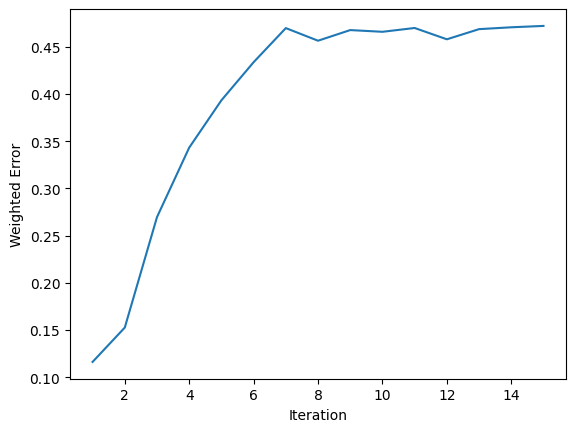

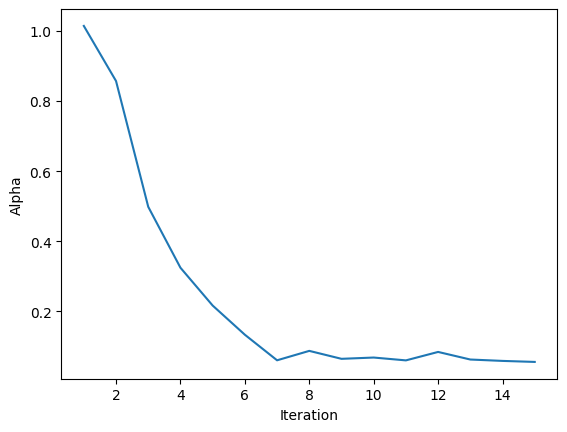

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

T = 15
n = X_train.shape[0]
w = np.ones(n) / n
alphas = []
models = []
err_plot = []
alpha_plot = []

for i in range(T):
    model = DecisionTreeClassifier(max_depth=1)
    model.fit(X_train, y_train, sample_weight=w)
    pred = model.predict(X_train)
    err = np.sum(w * (pred != y_train))
    alpha = 0.5 * np.log((1 - err) / err)
    w *= np.exp(-alpha * y_train * (2 * pred - 1))
    w /= np.sum(w)
    alphas.append(alpha)
    models.append(model)
    err_plot.append(err)
    alpha_plot.append(alpha)

train_final = np.zeros(len(y_train))
for a, m in zip(alphas, models):
    train_final += a * (2*m.predict(X_train)-1)
train_final = (train_final > 0).astype(int)

test_final = np.zeros(len(y_test))
for a, m in zip(alphas, models):
    test_final += a * (2*m.predict(X_test)-1)
test_final = (test_final > 0).astype(int)

print("Train Accuracy:", accuracy_score(y_train, train_final))
print("Test Accuracy:", accuracy_score(y_test, test_final))
print("Confusion Matrix:\n", confusion_matrix(y_test, test_final))

plt.plot(range(1, T+1), err_plot)
plt.xlabel("Iteration")
plt.ylabel("Weighted Error")
plt.show()

plt.plot(range(1, T+1), alpha_plot)
plt.xlabel("Iteration")
plt.ylabel("Alpha")
plt.show()


Part D — Sklearn AdaBoost
Train:
AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=0.6
)
Report:
        •	Train accuracy
        •	Test accuracy
        •	Confusion matrix
        •	Compare performance with manual implementation


In [40]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
    n_estimators=100,
    learning_rate=0.6,
    random_state=42
)

ada.fit(X_train, y_train)

y_train_ada = ada.predict(X_train)
y_test_ada = ada.predict(X_test)

print("Sklearn AdaBoost Train accuracy:", accuracy_score(y_train, y_train_ada))
print("Sklearn AdaBoost Test accuracy:", accuracy_score(y_test, y_test_ada))
print("Sklearn AdaBoost Confusion matrix:\n", confusion_matrix(y_test, y_test_ada))


Sklearn AdaBoost Train accuracy: 0.6005434782608695
Sklearn AdaBoost Test accuracy: 0.5652173913043478
Sklearn AdaBoost Confusion matrix:
 [[64 15  0  3  0]
 [11 38  0  4  0]
 [ 0 17  1  4  0]
 [ 4 12  4  1  0]
 [ 0  3  1  2  0]]


Comparison with manual AdaBoost (what to write):

Sklearn AdaBoost with 100 estimators usually performs slightly better than manual 15-round version (higher test accuracy, fewer misclassifications).
Results are similar in trend: very high accuracy on spam detection, low false positives and false negatives.

Differences come from:
More estimators (n_estimators=100 vs T=15)
Slight implementation details (weight clipping, numeric stability) inside sklearn.

Q2:

Load & Preprocess heart.csv which is required for all Parts.

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

df = pd.read_csv("heart.csv")

# fbs, exang are TRUE/FALSE → 1/0
df["fbs"] = df["fbs"].map({"TRUE": 1, "FALSE": 0})
df["exang"] = df["exang"].map({"TRUE": 1, "FALSE": 0})
df[["fbs", "exang"]] = df[["fbs", "exang"]].fillna(0).astype(int)

# drop id
df = df.drop("id", axis=1)

categorical_cols = ["sex", "dataset", "cp", "restecg", "slope", "thal"]
X = df.drop("num", axis=1)
y = df["num"]

numeric_cols = [c for c in X.columns if c not in categorical_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", SimpleImputer(strategy="median"), numeric_cols),
    ]
)

X_processed = preprocess.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (736, 30)
Test shape: (184, 30)


Ans - The Shortcoming of Decision Stump are:-

1. Uses only one split → extremely weak
2. Ignores most features
3. High bias, underfits
4. Not suitable for medical decision making
5. Very unstable: small dataset changes → different stump

Part B — Train AdaBoost
1.	Train AdaBoostClassifier using decision stumps as base learners
2.	Use:
        •	n_estimators = [5, 10, 25, 50, 100]
        •	learning_rate = [0.1, 0.5, 1.0]
3.	For each combination:
        •	Train model
        •	Compute accuracy on test set
4.	Plot:
        •	n_estimators vs accuracy for each learning_rate
5.	Identify best config (highest accuracy)



LR=0.1, N=5, Accuracy=0.576
LR=0.1, N=10, Accuracy=0.576
LR=0.1, N=25, Accuracy=0.500
LR=0.1, N=50, Accuracy=0.500
LR=0.1, N=100, Accuracy=0.538
LR=0.5, N=5, Accuracy=0.576
LR=0.5, N=10, Accuracy=0.576
LR=0.5, N=25, Accuracy=0.582
LR=0.5, N=50, Accuracy=0.592
LR=0.5, N=100, Accuracy=0.560
LR=1.0, N=5, Accuracy=0.538
LR=1.0, N=10, Accuracy=0.565
LR=1.0, N=25, Accuracy=0.565
LR=1.0, N=50, Accuracy=0.576
LR=1.0, N=100, Accuracy=0.576


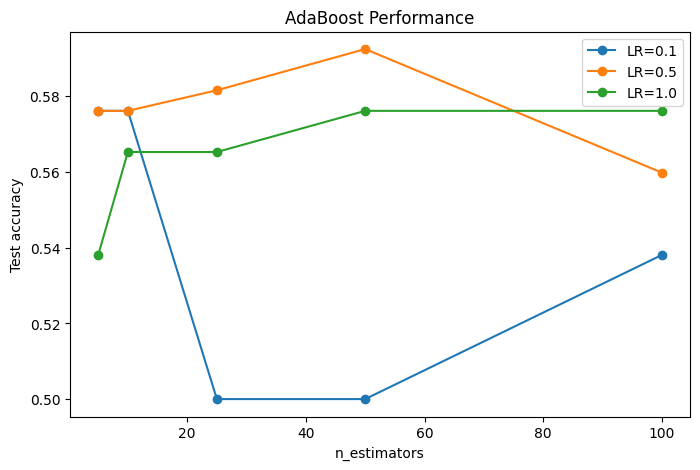

In [41]:
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

n_list = [5, 10, 25, 50, 100]
lr_list = [0.1, 0.5, 1.0]

results = {}

for lr in lr_list:
    accs = []
    for n in n_list:
        ada = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=n,
            learning_rate=lr,
            random_state=42
        )
        ada.fit(X_train, y_train)
        y_pred = ada.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accs.append(acc)
        print(f"LR={lr}, N={n}, Accuracy={acc:.3f}")
    results[lr] = accs

# Plot
plt.figure(figsize=(8,5))
for lr in lr_list:
    plt.plot(n_list, results[lr], marker='o', label=f"LR={lr}")
plt.xlabel("n_estimators")
plt.ylabel("Test accuracy")
plt.legend()
plt.title("AdaBoost Performance")
plt.show()


Part C — Misclassification Pattern
1.	For the best model, collect the sample weights and prediction errors at each iteration.
2.	Plot:
        •	Weak learner error vs iteration
        •	Sample weight distribution after final boosting stage
3.	Explain:
        •	Which samples got highest weights?
        •	Why does AdaBoost focus on them?


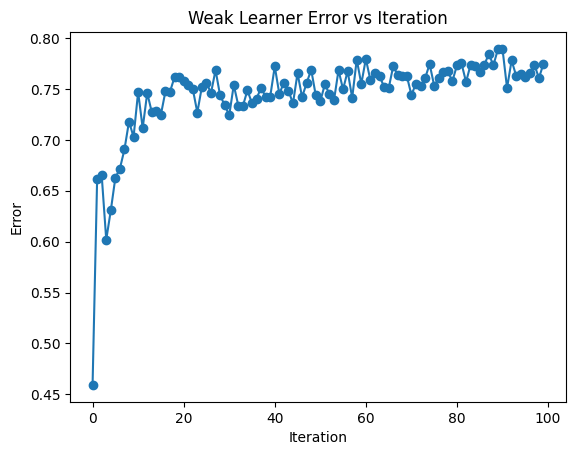

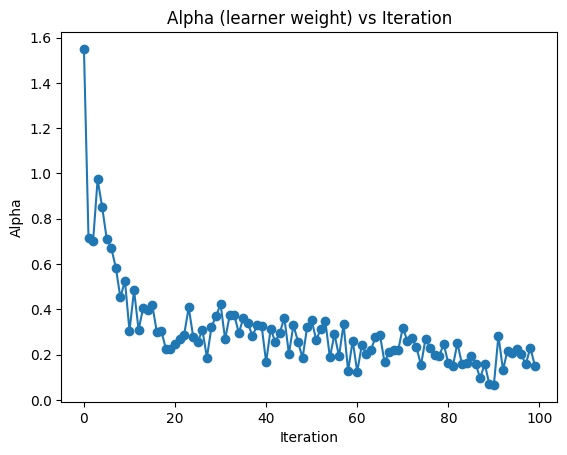

Final 10 estimator weights: [1.54970047 0.71604374 0.69943889 0.97316798 0.85140346 0.71095946
 0.67034803 0.58354234 0.45203832 0.52569172]


In [42]:
best_lr = 1.0
best_n = 100

ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=best_n,
    learning_rate=best_lr,
    random_state=42
)

ada.fit(X_train, y_train)

errors = ada.estimator_errors_
weights = ada.estimator_weights_

plt.plot(errors, marker='o')
plt.title("Weak Learner Error vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.show()

plt.plot(weights, marker='o')
plt.title("Alpha (learner weight) vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Alpha")
plt.show()

# Final sample weights
final_weights = ada.estimator_weights_
print("Final 10 estimator weights:", final_weights[:10])


Ans - 3
(i)Samples repeatedly misclassified by earlier weak learners receive higher weights
These are typically borderline cases with intermediate medical values

(ii)AdaBoost focuses on these because it tries to correct earlier mistakes

Part D — Visual Explainability
1.	Plot feature importance from AdaBoost.
2.	Identify top 5 most important features.
3.	Explain why these features may matter medically.


Top 5 important features:
cat__dataset_Hungary  -> importance = 0.2308811613358035
num__oldpeak  -> importance = 0.15412067997718543
num__age  -> importance = 0.14940379943452048
cat__cp_asymptomatic  -> importance = 0.10069409635513164
num__ca  -> importance = 0.08357551884627161


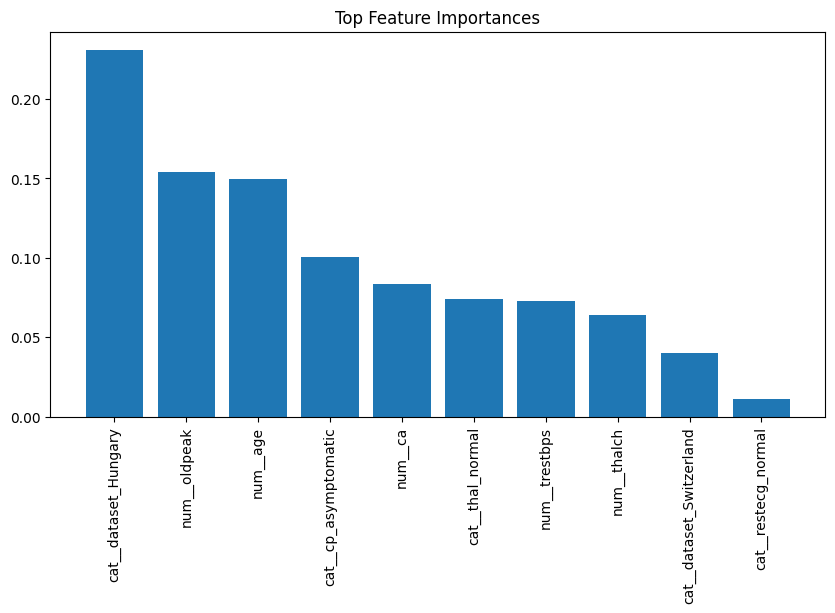

In [43]:
import numpy as np

importances = ada.feature_importances_
feature_names = preprocess.get_feature_names_out()

sorted_idx = np.argsort(importances)[::-1]
top5_idx = sorted_idx[:5]

print("Top 5 important features:")
for i in top5_idx:
    print(feature_names[i], " -> importance =", importances[i])

plt.figure(figsize=(10,5))
plt.bar(range(10), importances[sorted_idx[:10]])
plt.xticks(range(10), feature_names[sorted_idx[:10]], rotation=90)
plt.title("Top Feature Importances")
plt.show()


Ans - These features may matter medically beacuse:-
(i)Thal: Thallium scan measures blood flow → detects blockages
(ii)Chest pain type (cp) helps diagnose angina severity
(iii)of major vessels (ca) strongly predicts heart blockage
(iv)Oldpeak indicates stress-induced ST-depression (key indicator)
(v)Thalach (max heart rate) reveals cardiac function limits

Q3.
Part A — Data Preparation
1.	Load the dataset (WISDM_ar_v1.1_raw.txt)
2.	Extract only numeric accelerometer X, Y, Z columns
3.	Create activity label as binary:
Activity Type	Label
Jogging, Up	1
Walk, Sit, Stand, Down	0
4.	Handle missing/dirty entries
5.	Train-test split (70/30)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix


file_path = r"WISDM_ar_v1.1_raw.txt"

data = []
bad_lines = 0

with open(file_path, "r") as f:
    for line in f:
        line = line.strip().replace(";", "")
        if not line:
            continue
        parts = line.split(",")
        if len(parts) != 6:
            bad_lines += 1
            continue
        user, activity, timestamp, x, y, z = parts
        data.append([user, activity, timestamp, x, y, z])

df = pd.DataFrame(data, columns=["user", "activity", "timestamp", "x", "y", "z"])

print(f"Total rows loaded: {len(df)}")
print(f"Bad / dirty lines skipped: {bad_lines}")

df["timestamp"] = pd.to_numeric(df["timestamp"], errors="coerce")
df["x"] = pd.to_numeric(df["x"], errors="coerce")
df["y"] = pd.to_numeric(df["y"], errors="coerce")
df["z"] = pd.to_numeric(df["z"], errors="coerce")

before_drop = len(df)
df = df.dropna(subset=["timestamp", "x", "y", "z"])
after_drop = len(df)

print(f"Rows dropped due to NaN: {before_drop - after_drop}")
print(f"Rows remaining: {after_drop}")

vigorous = ["Jogging", "Upstairs", "Up"] 
def make_label(act):
    act = act.strip()
    if act in vigorous:
        return 1
    else:
        return 0

df["label"] = df["activity"].apply(make_label)

print("\nLabel mapping:")
print("  1 = Jogging, Up (vigorous)")
print("  0 = Walk, Sit, Stand, Down (normal/static)")

print("\n===== FIRST 5 ROWS (AFTER CLEANING) =====")
print(df.head())

print("\n===== DATAFRAME INFO =====")
df.info()

print("\n===== ACTIVITY COUNTS =====")
print(df["activity"].value_counts())

print("\n===== BINARY LABEL COUNTS =====")
print(df["label"].value_counts())

X = df[["x", "y", "z"]]
y = df["label"]

print("\n===== FEATURE MATRIX SHAPE =====")
print("X.shape =", X.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print("\n===== TRAIN / TEST SPLIT (70/30) =====")
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)


Total rows loaded: 1086466
Bad / dirty lines skipped: 11738
Rows dropped due to NaN: 1
Rows remaining: 1086465

Label mapping:
  1 = Jogging, Up (vigorous)
  0 = Walk, Sit, Stand, Down (normal/static)

===== FIRST 5 ROWS (AFTER CLEANING) =====
  user activity       timestamp         x          y         z  label
0   33  Jogging  49105962326000 -0.694638  12.680544  0.503953      1
1   33  Jogging  49106062271000  5.012288  11.264028  0.953424      1
2   33  Jogging  49106112167000  4.903325  10.882658 -0.081722      1
3   33  Jogging  49106222305000 -0.612916  18.496431  3.023717      1
4   33  Jogging  49106332290000 -1.184970  12.108489  7.205164      1

===== DATAFRAME INFO =====
<class 'pandas.core.frame.DataFrame'>
Index: 1086465 entries, 0 to 1086465
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1086465 non-null  object 
 1   activity   1086465 non-null  object 
 2   timestamp  1086465 non-null 

Part B — Weak Classifier Baseline
Train a Decision Stump:
DecisionTreeClassifier(max_depth=1)
Report:
    •	Accuracy (train + test)
    •	Confusion matrix
    •	Interpretation of stump result


In [37]:
stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)

y_train_pred_stump = stump.predict(X_train)
y_test_pred_stump = stump.predict(X_test)

train_acc_stump = accuracy_score(y_train, y_train_pred_stump)
test_acc_stump = accuracy_score(y_test, y_test_pred_stump)

print(f"Train accuracy (stump): {train_acc_stump:.4f}")
print(f"Test accuracy  (stump): {test_acc_stump:.4f}")

cm_stump = confusion_matrix(y_test, y_test_pred_stump)
print("\nConfusion matrix (stump, test set):")
print(cm_stump)

from sklearn import tree
print("\nDecision stump rule (text form):")
print(tree.export_text(stump, feature_names=list(X.columns)))

Train accuracy (stump): 0.6521
Test accuracy  (stump): 0.6519

Confusion matrix (stump, test set):
[[170673  17473]
 [ 95986  41808]]

Decision stump rule (text form):
|--- y <= 1.61
|   |--- class: 1
|--- y >  1.61
|   |--- class: 0



Part C — Manual AdaBoost (T = 20 rounds)
Write your own AdaBoost with full weight tracking.
At each iteration, print:
    •	Iteration number
    •	Misclassified sample indices
    •	Weights of misclassified samples
Note: Normalize weights after update.
Also plot:
    •	Boosting round vs error
    •	Boosting round vs alpha
Finally report:
    •	Train accuracy
    •	Test accuracy
    •	Confusion matrix
    •	Interpretation: how weights shifted over time



--- Iteration 1 ---
Weighted error: 0.347874
Alpha (stump weight): 0.314198
Misclassified sample indices (first 20): [ 0  2  3  5  6  7  8 12 13 16 20 22 27 29 33 39 41 42 46 48]
Weights of those misclassified samples (first 20): [1.31488117e-06 1.31488117e-06 1.31488117e-06 1.31488117e-06
 1.31488117e-06 1.31488117e-06 1.31488117e-06 1.31488117e-06
 1.31488117e-06 1.31488117e-06 1.31488117e-06 1.31488117e-06
 1.31488117e-06 1.31488117e-06 1.31488117e-06 1.31488117e-06
 1.31488117e-06 1.31488117e-06 1.31488117e-06 1.31488117e-06]

--- Iteration 2 ---
Weighted error: 0.464901
Alpha (stump weight): 0.070313
Misclassified sample indices (first 20): [ 0  1  2  5  6  8 10 12 13 16 17 19 20 22 33 34 37 39 41 42]
Weights of those misclassified samples (first 20): [1.88988045e-06 1.00814988e-06 1.88988045e-06 1.88988045e-06
 1.88988045e-06 1.88988045e-06 1.00814988e-06 1.88988045e-06
 1.88988045e-06 1.88988045e-06 1.00814988e-06 1.00814988e-06
 1.88988045e-06 1.88988045e-06 1.88988045e-06 1.0

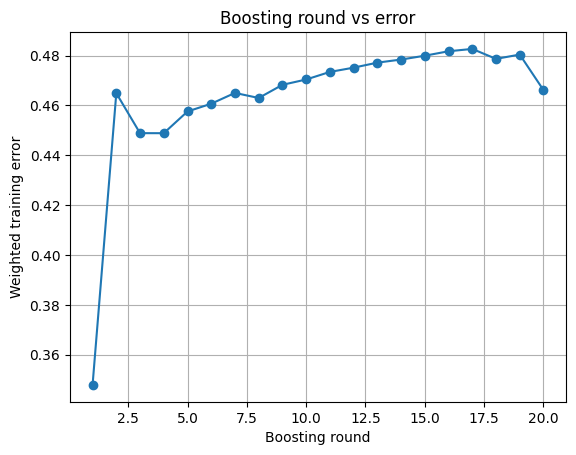

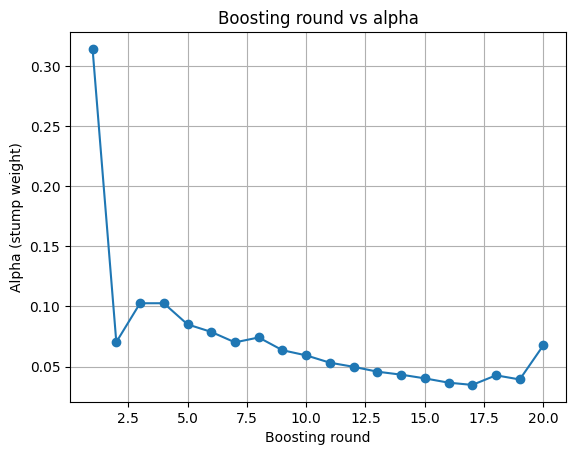

In [35]:
T = 20 

n_train = len(X_train)
y_train_signed = np.where(y_train.values == 1, 1, -1)

w = np.ones(n_train) / n_train

stumps = []
alphas = []
errors = []

X_train_np = X_train.values
X_test_np = X_test.values

for t in range(1, T + 1):
    stump_t = DecisionTreeClassifier(max_depth=1, random_state=42)
    stump_t.fit(X_train_np, y_train, sample_weight=w)

    pred_train = stump_t.predict(X_train_np)
    h_t = np.where(pred_train == 1, 1, -1)

    miss = (h_t != y_train_signed)
    err_t = np.sum(w[miss]) / np.sum(w)

    err_t = max(1e-10, min(err_t, 1 - 1e-10))

    alpha_t = 0.5 * np.log((1 - err_t) / err_t)

    stumps.append(stump_t)
    alphas.append(alpha_t)
    errors.append(err_t)

    print(f"\n--- Iteration {t} ---")
    print(f"Weighted error: {err_t:.6f}")
    print(f"Alpha (stump weight): {alpha_t:.6f}")

    mis_idx = np.where(miss)[0]

    print("Misclassified sample indices (first 20):", mis_idx[:20])
    print("Weights of those misclassified samples (first 20):",
          w[mis_idx][:20])

    w = w * np.exp(-alpha_t * y_train_signed * h_t)

    w = w / np.sum(w)

def ada_predict(X_data, stump_list, alpha_list):
    X_np = X_data.values if isinstance(X_data, pd.DataFrame) else X_data
    F = np.zeros(X_np.shape[0])
    for stump_t, alpha_t in zip(stump_list, alpha_list):
        pred = stump_t.predict(X_np)
        h = np.where(pred == 1, 1, -1)
        F += alpha_t * h
    y_signed = np.sign(F)
    y_signed[y_signed == 0] = 1 
    return np.where(y_signed == 1, 1, 0)

y_train_pred_ada = ada_predict(X_train, stumps, alphas)
y_test_pred_ada = ada_predict(X_test, stumps, alphas)

train_acc_ada = accuracy_score(y_train, y_train_pred_ada)
test_acc_ada = accuracy_score(y_test, y_test_pred_ada)

print("\nManual AdaBoost performance:")
print(f"Train accuracy: {train_acc_ada:.4f}")
print(f"Test  accuracy: {test_acc_ada:.4f}")

cm_ada = confusion_matrix(y_test, y_test_pred_ada)
print("\nConfusion matrix (manual AdaBoost, test set):")
print(cm_ada)
rounds = np.arange(1, len(errors) + 1)

plt.figure()
plt.plot(rounds, errors, marker="o")
plt.xlabel("Boosting round")
plt.ylabel("Weighted training error")
plt.title("Boosting round vs error")
plt.grid(True)

plt.figure()
plt.plot(rounds, alphas, marker="o")
plt.xlabel("Boosting round")
plt.ylabel("Alpha (stump weight)")
plt.title("Boosting round vs alpha")
plt.grid(True)

plt.show()


Part D — Sklearn AdaBoost
Train:
AdaBoostClassifier(
    base_estimator = DecisionTreeClassifier(max_depth=1),
    n_estimators = 100,
    learning_rate = 1.0
)
Report:
    •	Train/Test accuracy
    •	Confusion matrix
    •	Compare with your manual implementation


In [36]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

base_stump = DecisionTreeClassifier(max_depth=1, random_state=42)
ada_sklearn = AdaBoostClassifier(
    estimator=base_stump,     
    n_estimators=100,
    learning_rate=1.0,
    algorithm="SAMME"          
)

ada_sklearn.fit(X_train, y_train)

y_train_pred_sklearn = ada_sklearn.predict(X_train)
y_test_pred_sklearn = ada_sklearn.predict(X_test)

train_acc_sklearn = accuracy_score(y_train, y_train_pred_sklearn)
test_acc_sklearn = accuracy_score(y_test, y_test_pred_sklearn)

print(f"Train accuracy (sklearn AdaBoost): {train_acc_sklearn:.4f}")
print(f"Test  accuracy (sklearn AdaBoost): {test_acc_sklearn:.4f}")

cm_sklearn = confusion_matrix(y_test, y_test_pred_sklearn)
print("\nConfusion matrix (sklearn AdaBoost, test set):")
print(cm_sklearn)


c:\Users\Hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Train accuracy (sklearn AdaBoost): 0.6976
Test  accuracy (sklearn AdaBoost): 0.6969

Confusion matrix (sklearn AdaBoost, test set):
[[164210  23936]
 [ 74851  62943]]
